# LeNet5
: 32*32 크기의 흑백 이미지에서 학습된 7 layers conv CNN

featrue_extract으로 feature를 추출한 후 classificate

input = (32,32,3)

conv1(32,28,5,2) -> (6,28,28) / 훈련해야할 파라미터:(가중치*입력맵개수 + 바이어스)*특성맵개수 = (5*5*1 + 1)*6 = 156

avepool(2,2) -> (6,14,14)/ 훈련해야할 파라미터 개수: (가중치 + 바이어스)*특성맵개수 = (1 + 1)*6 = 12





In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets,transforms

import matplotlib.pyplot as plt


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## parameter

In [3]:
RANDOM_SEED = 42
LEATRING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10      #MNIST datasets with 10 classes

## transform

In [4]:
transfrom = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.ToTensor()])

## Download dataset

In [5]:
train_dataset = datasets.MNIST(root='./mnist_data',
                              train=True,
                              transform=transfrom,
                              download=True)
valid_dataset = datasets.MNIST(root='./mnist_data',
                               train=False,
                               transform=transfrom)

## Dataloader

In [6]:
train_loader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

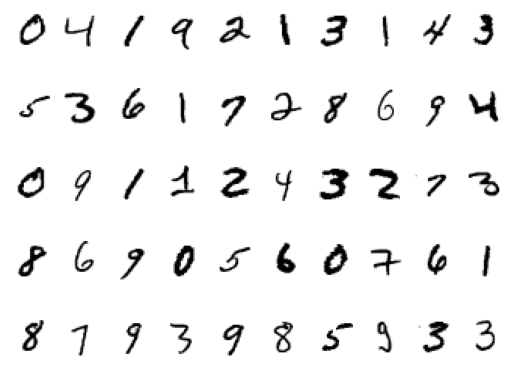

In [7]:
#data check
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG*N_ROWS+1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')

plt.show()

## Model

In [8]:
"""
start  torch.Size([32, 1, 32, 32])
after feature_extraction:  torch.Size([32, 120, 1, 1])
after flatten:  torch.Size([32, 120])
after classification:  torch.Size([32, 120])

"""

'\nstart  torch.Size([32, 1, 32, 32])\nafter feature_extraction:  torch.Size([32, 120, 1, 1])\nafter flatten:  torch.Size([32, 120])\nafter classification:  torch.Size([32, 120])\n\n'

In [17]:
class LeNet5(nn.Module):
    def __init__(self, n_classes):
        super(LeNet5,self).__init__()

        # 이미지 특징 추출
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 6, 5, 1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(6, 16, 5, 1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(16, 120, 5, 1),
            nn.Tanh()
        )

        # 추출된 특징으로 클래스 예측
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)     #1차원 변환
        logits = self.classifier(x)             #순수한 모델의 예측값
        probs = F.softmax(logits, dim=1)        #클래스 분류에 대한 확률값
        return logits, probs

## Accuary

In [16]:
# data_loader에 대한 예측 정확도 계산
def get_acc(model, data_loader, device):
    corr = 0
    n = 0

    with torch.no_grad():
        model.eval()

        for X, y_true in data_loader:
            # device로 불러오기
            X = X.to(device)
            y_true = y_true.to(device)
            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob,1)

            n += y_true.size(0)
            corrected_pred = (predicted_labels==y_true).sum()

    return corrected_pred.float()/n

## Loss

In [11]:
# taining/ valid loss시각화
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_losses, color='b', label='Training loss')
    ax.plot(valid_losses, color='r', label= 'Validation loss')
    ax.set(title='Loss over epochs', xlabel='Epoch', ylabel='Loss')
    ax.legend()
    fig.show()

    plt.style.use('default')

## Validation

In [12]:
def validate(valid_loader, model, criterion, devcie):
    model.eval()

    running_loss = 0

    for X, y_true in valid_loader:
        X = X.to(device)
        y_true = y_true.to(device)


        outputs,_ = model(X)        #output : logit
        loss = criterion(outputs, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
    
    return model, epoch_loss

## Training

In [30]:
def train(train_loader, model, criterion, optimizer,device):
    model.train()
    running_loss = 0

    for X, y_true in train_loader:
        
        optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)

        outputs, probs = model(X)       #모델의 반환값 prob는 무시하기 위해
        loss = criterion(outputs, y_true)
        running_loss += loss.item() * X.size(0)

        loss.backward()
        optimizer.step()

    epoch_loss = running_loss/ len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [31]:
def training_loop(model, criterion, optimizer, train_loader,valid_loader, epochs, deivce,print_every=1):

    train_losses= []
    valid_losses = []

    for epoch in range(0, epochs):

        #training
        model, optimizer, train_loss = train(train_loader,model, criterion, optimizer, device)
        train_losses.append(train_loss)

        #validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every-1):
            train_acc = get_acc(model, train_loader, device)
            valid_acc = get_acc(model, valid_loader, device)

            print(f"epcoh: {epoch+1} \t"
                  f"Train loss: {train_loss:.3f}\t"
                  f"Valid loss: {valid_loss:.3f}\t"
                  f"Train acc: {100*train_acc:.3f}\t"
                  f"Valid acc: {100*valid_acc:.3f}")
            
    plot_loss(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [32]:
if __name__ == '__main__':
    torch.manual_seed(RANDOM_SEED)

    model = LeNet5(N_CLASSES).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr= LEATRING_RATE)
    criterion = nn.CrossEntropyLoss()
    model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, device)


output: tensor([[ 0.1060, -0.1225,  0.0409,  0.0281, -0.0446, -0.0902, -0.0984, -0.0313,
         -0.0156, -0.0231],
        [ 0.1367, -0.1290,  0.0639,  0.0368, -0.0064, -0.1132, -0.0979, -0.0580,
         -0.0130,  0.0182],
        [ 0.1253, -0.1145,  0.0483,  0.0108, -0.0215, -0.0791, -0.1120, -0.0031,
         -0.0178,  0.0145],
        [ 0.0977, -0.1106,  0.0423,  0.0002, -0.0406, -0.0847, -0.1074,  0.0011,
         -0.0432, -0.0270],
        [ 0.1157, -0.1345,  0.0427,  0.0128, -0.0122, -0.0851, -0.1029, -0.0604,
          0.0047,  0.0265],
        [ 0.1493, -0.1253,  0.0589,  0.0434, -0.0167, -0.1168, -0.0885, -0.0543,
          0.0166,  0.0094],
        [ 0.1243, -0.1110,  0.0379,  0.0079, -0.0404, -0.0863, -0.1125,  0.0031,
         -0.0306, -0.0198],
        [ 0.1352, -0.1061,  0.0505,  0.0051, -0.0376, -0.0893, -0.1063, -0.0114,
         -0.0087, -0.0190],
        [ 0.1065, -0.1165,  0.0471,  0.0074, -0.0288, -0.0703, -0.0967,  0.0043,
         -0.0327, -0.0131],
        [ 0

output: tensor([[ 0.1778, -0.0918, -0.0651,  0.1179, -0.1134, -0.0543, -0.0632, -0.1161,
         -0.0627, -0.0933],
        [ 0.0715,  0.0157, -0.0496,  0.0615, -0.1201, -0.0431, -0.1069, -0.0550,
         -0.1171, -0.1208],
        [ 0.2105, -0.0810, -0.0508,  0.0715, -0.1062, -0.1162, -0.0516, -0.0846,
         -0.0431, -0.0676],
        [ 0.1098,  0.0181, -0.0357,  0.0592, -0.1231, -0.0530, -0.1071, -0.0685,
         -0.1001, -0.1175],
        [ 0.1286, -0.0688, -0.0551,  0.1271, -0.1081, -0.0442, -0.0710, -0.0943,
         -0.0643, -0.1027],
        [ 0.1309, -0.0523, -0.0580,  0.1332, -0.1300, -0.0681, -0.0819, -0.0851,
         -0.0815, -0.1272],
        [ 0.1473, -0.0578, -0.0280,  0.0862, -0.0749, -0.0611, -0.1010, -0.0624,
         -0.0859, -0.0797],
        [ 0.1698, -0.0529, -0.0567,  0.1225, -0.1265, -0.0789, -0.0585, -0.1121,
         -0.0545, -0.0958],
        [ 0.2123, -0.1095, -0.0750,  0.1096, -0.1317, -0.0649, -0.0637, -0.1226,
         -0.0545, -0.0904],
        [ 0

KeyboardInterrupt: 